### **High Frequency Trading Strategies Design using ML and DL**

In [29]:
# -*- coding: utf-8 -*-
"""
Created on Sun Mar 13 22:40:00 2022

@author: Bradley

HFT: Machine Learning Techniques on Full Orderbook Tick Data
"""

'\nCreated on Sun Mar 13 22:40:00 2022\n\n@author: Bradley\n\nHFT: Machine Learning Techniques on Full Orderbook Tick Data\n'

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime
import csv

plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (8,5) #提前设置图片形状大小

%config InlineBackend.figure_format = 'svg'

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')  # 忽略一些warnings

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display
pd.set_option('expand_frame_repr', False)
pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)
pd.set_option('display.width', 180)

### **Orderbook Data Visualization**

In [31]:
# obtain columns respectively from orderbook
def order_book(month,day):
    data = []
    datapath = './data/order_book_3_2014' + '_' + str(1) + '_' + str(2) + '.csv'
    order = pd.read_csv(datapath,sep=',')
    bid_price_1 = np.array(order['Bid'][1::4].astype("float64"))/100 #bid1
    bid_price_2 = np.array(order['Bid'][2::4].astype("float64"))/100 #bid2
    bid_price_3 = np.array(order['Bid'][3::4].astype("float64"))/100 #bid3
    timestamp = np.array(order['Bid_Quantity'][0::4]) #每个tick data的时间
    bid_quantity_1 = np.array(order['Bid_Quantity'][1::4].astype("float64"))/100 #bidqty1
    bid_quantity_2 = np.array(order['Bid_Quantity'][2::4].astype("float64"))/100 #bidqty2
    bid_quantity_3 = np.array(order['Bid_Quantity'][3::4].astype("float64"))/100 #bidqty3
    ask_price_1 = np.array(order['Ask'][1::4].astype("float64"))/100 #ask1
    ask_price_2 = np.array(order['Ask'][2::4].astype("float64"))/100 #ask2
    ask_price_3 = np.array(order['Ask'][3::4].astype("float64"))/100 #ask3
    ask_quantity_1 = np.array(order['Ask_Quantity'][1::4].astype("float64"))/100 #askqty1
    ask_quantity_2 = np.array(order['Ask_Quantity'][2::4].astype("float64"))/100 #askqty1
    ask_quantity_3 = np.array(order['Ask_Quantity'][3::4].astype("float64"))/100 #askqty1
    
    # 填充缺失值为0
    bid_quantity_1[np.isnan(bid_quantity_1)] = 0
    bid_quantity_2[np.isnan(bid_quantity_2)] = 0
    bid_quantity_3[np.isnan(bid_quantity_3)] = 0
    ask_quantity_1[np.isnan(ask_quantity_1)] = 0
    ask_quantity_2[np.isnan(ask_quantity_2)] = 0
    ask_quantity_3[np.isnan(ask_quantity_3)] = 0
    
    return timestamp,order,bid_price_1,bid_price_2,bid_price_3,bid_quantity_1,\
            bid_quantity_2,bid_quantity_3,ask_price_1,ask_price_2,ask_price_3,ask_quantity_1,\
            ask_quantity_2,ask_quantity_3

In [32]:
# time_second是将timestamp数据格式转换为全按分钟计算
# time_second_basic是讲上面的转换结果减去一个32400
# 作用是使得上午的交易时间[0, 9000]对应09:00 ~ 11:30，下午的交易时间[14400, 25200]对应13:00 ~ 16:00，借以将上下午分开
def time_transform(timestamp_time):
    time_second_basic = []
    time_second = []
    for i in range(0,len(timestamp_time),1):
        second = float(timestamp_time[i][11])*36000 + float(timestamp_time[i][12])*3600+\
                    float(timestamp_time[i][14])*600 + float(timestamp_time[i][15])*60+\
                    float(timestamp_time[i][17])*10 + float(timestamp_time[i][18])  
        time_second_basic.append(second - 32400.0)
        time_second.append(second)
    return np.array(time_second),np.array(time_second_basic)

In [33]:
# 读取数据
month = 1
day = 2
timestamp,order,bid_price_1,bid_price_2,bid_price_3,\
bid_quantity_1,bid_quantity_2,bid_quantity_3,\
ask_price_1,ask_price_2,ask_price_3,ask_quantity_1,\
ask_quantity_2,ask_quantity_3 = order_book(month,day)
order

,Bid,Bid_Quantity,Ask,Ask_Quantity
0,TimeStamp,2014-01-02D08:45:00.296582600,NaN,NaN
1,708000,210,682000.0,210.0
2,700500,2,715500.0,2.0
3,699000,2,717500.0,1.0
4,TimeStamp,2014-01-02D08:45:00.296582600,NaN,NaN
...,...,...,...,...
186715,703000.0,27.0,705000.0,167.0
186716,TimeStamp,2014-01-02D16:00:00.024493700,NaN,NaN
186717,703500.0,150.0,704000.0,23.0
186718,703000.0,27.0,704500.0,18.0


- 1. 应该取秒为单位的数据，而不是tick做可视化
- 2. 应该筛选掉9:00以前的数据

In [86]:
# 转换时间格式
time_second,time_second_basic = time_transform(timestamp)
print(time_second)
print(time_second_basic)
Ask1 = ask_price_1[np.where(time_second_basic <= 0.0)[0][-1]:]
Bid1 = bid_price_1[np.where(time_second_basic <= 0.0)[0][-1]:]

[31500. 31500. 31500. ... 57594. 57595. 57600.]
[ -900.  -900.  -900. ... 25194. 25195. 25200.]


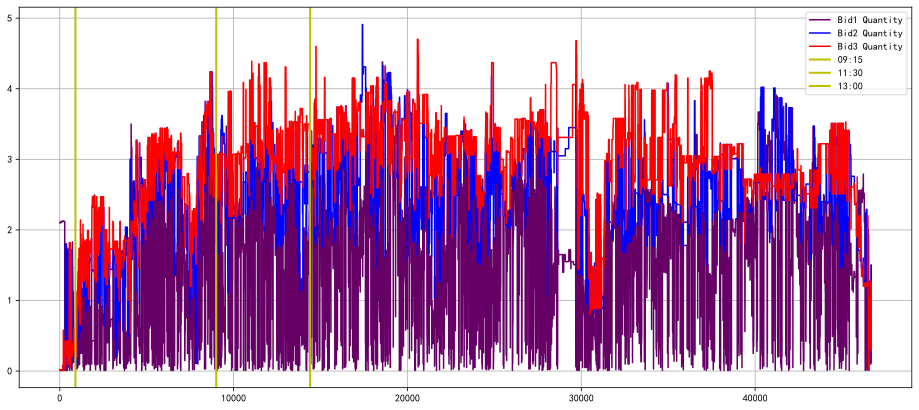

In [49]:
import matplotlib.pyplot as plt
plt.figure(figsize = (16,7))
plt.grid()
plt.plot(bid_quantity_1,label = 'Bid1 Quantity',color = '#660066')
plt.plot(bid_quantity_2,label = 'Bid2 Quantity',color = 'b')
plt.plot(bid_quantity_3,label = 'Bid3 Quantity',color = 'r')
# plt.xlim(0.0,25200)
plt.axvline(x = 900 ,color = 'y',linestyle = '-',label = '09:15', linewidth = 2)
plt.axvline(x = 9000 ,color = 'y',linestyle = '-',label = '11:30', linewidth = 2)
plt.axvline(x = 14400 ,color = 'y',linestyle = '-',label = '13:00', linewidth = 2)

plt.legend(loc = 1)

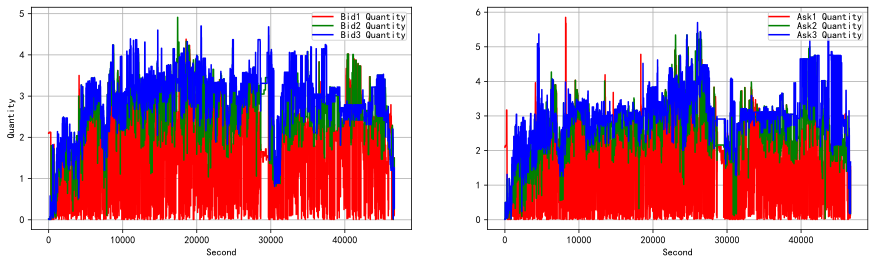

In [51]:
import matplotlib.pyplot as plt
plt.figure(figsize = (15,9))
plt.subplot(221)
plt.grid()
plt.plot(bid_quantity_1,label = 'Bid1 Quantity',color = 'r')
plt.plot(bid_quantity_2,label = 'Bid2 Quantity',color = 'g')
plt.plot(bid_quantity_3,label = 'Bid3 Quantity',color = 'b')
# plt.xlim(0.0,25200)
plt.xlabel("Second")
plt.ylabel("Quantity")
#plt.axvline(x = 900 ,color = 'y',linestyle = '-',label = '09:15', linewidth = 2)
#plt.axvline(x = 9000 ,color = 'y',linestyle = '-',label = '11:30', linewidth = 2)
#plt.axvline(x = 14400 ,color = 'y',linestyle = '-',label = '13:00', linewidth = 2)
plt.legend(loc = 1,borderpad = 0.08,labelspacing = 0.08)

plt.subplot(222)
plt.grid()
plt.plot(ask_quantity_1,label = 'Ask1 Quantity',color = 'r')
plt.plot(ask_quantity_2,label = 'Ask2 Quantity',color = 'g')
plt.plot(ask_quantity_3,label = 'Ask3 Quantity',color = 'b')
plt.xlabel("Second")
#plt.axvline(x = 900 ,color = 'y',linestyle = '-',label = '09:15', linewidth = 2)
#plt.axvline(x = 9000 ,color = 'y',linestyle = '-',label = '11:30', linewidth = 2)
#plt.axvline(x = 14400 ,color = 'y',linestyle = '-',label = '13:00', linewidth = 2)
# plt.xlim(0.0,25200)
plt.legend(loc = 1,borderpad = 0.08,labelspacing = 0.08)

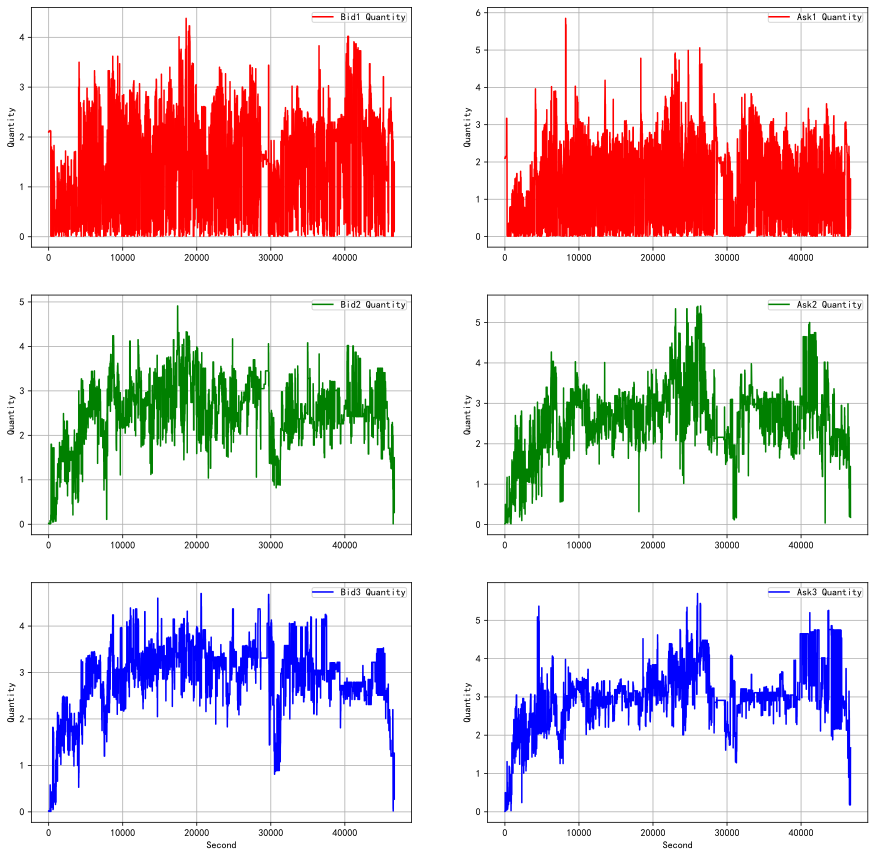

In [53]:
plt.figure(figsize = (15,15))
plt.subplot(321)
plt.grid()
plt.plot(bid_quantity_1,label = 'Bid1 Quantity',color = 'r')
# plt.xlim(0.0,25200)
# plt.axvline(x = 900 ,color = 'y',linestyle = '-',label = '09:15', linewidth = 2)
# plt.axvline(x = 9000 ,color = 'y',linestyle = '-',label = '11:30', linewidth = 2)
# plt.axvline(x = 14400 ,color = 'y',linestyle = '-',label = '13:00', linewidth = 2)
#plt.xlabel("Second")
plt.ylabel("Quantity")
plt.legend(loc = 1,borderpad = 0.08,labelspacing = 0.08)

plt.subplot(323)
plt.grid()
plt.plot(bid_quantity_2,label = 'Bid2 Quantity',color = 'g')
# plt.xlim(0.0,25200)
# plt.axvline(x = 900 ,color = 'y',linestyle = '-',label = '09:15', linewidth = 2)
# plt.axvline(x = 9000 ,color = 'y',linestyle = '-',label = '11:30', linewidth = 2)
# plt.axvline(x = 14400 ,color = 'y',linestyle = '-',label = '13:00', linewidth = 2)
#plt.xlabel("Second")
plt.ylabel("Quantity")
plt.legend(loc = 1,borderpad = 0.08,labelspacing = 0.08)
plt.subplot(325)

plt.grid()
plt.plot(bid_quantity_3,label = 'Bid3 Quantity',color = 'b')
# plt.xlim(0.0,25200)
# plt.axvline(x = 900 ,color = 'y',linestyle = '-',label = '09:15', linewidth = 2)
# plt.axvline(x = 9000 ,color = 'y',linestyle = '-',label = '11:30', linewidth = 2)
# plt.axvline(x = 14400 ,color = 'y',linestyle = '-',label = '13:00', linewidth = 2)
plt.xlabel("Second")
plt.ylabel("Quantity")
plt.legend(loc = 1,borderpad = 0.08,labelspacing = 0.08)
plt.subplot(322)

plt.grid()
plt.plot(ask_quantity_1,label = 'Ask1 Quantity',color = 'r')
# plt.xlim(0.0,25200)
# plt.axvline(x = 900 ,color = 'y',linestyle = '-',label = '09:15', linewidth = 2)
# plt.axvline(x = 9000 ,color = 'y',linestyle = '-',label = '11:30', linewidth = 2)
# plt.axvline(x = 14400 ,color = 'y',linestyle = '-',label = '13:00', linewidth = 2)
#plt.xlabel("Second")
plt.ylabel("Quantity")
plt.legend(loc = 1,borderpad = 0.08,labelspacing = 0.08)

plt.subplot(324)
plt.grid()
plt.plot(ask_quantity_2,label = 'Ask2 Quantity',color = 'g')
# plt.xlim(0.0,25200)
# plt.axvline(x = 900 ,color = 'y',linestyle = '-',label = '09:15', linewidth = 2)
# plt.axvline(x = 9000 ,color = 'y',linestyle = '-',label = '11:30', linewidth = 2)
# plt.axvline(x = 14400 ,color = 'y',linestyle = '-',label = '13:00', linewidth = 2)
#plt.xlabel("Second")
plt.ylabel("Quantity")
plt.legend(loc = 1,borderpad = 0.08,labelspacing = 0.08)

plt.subplot(326)
plt.grid()
plt.plot(ask_quantity_3,label = 'Ask3 Quantity',color = 'b')
# plt.xlim(0.0,25200)
# plt.axvline(x = 900 ,color = 'y',linestyle = '-',label = '09:15', linewidth = 2)
# plt.axvline(x = 9000 ,color = 'y',linestyle = '-',label = '11:30', linewidth = 2)
# plt.axvline(x = 14400 ,color = 'y',linestyle = '-',label = '13:00', linewidth = 2)
plt.xlabel("Second")
plt.ylabel("Quantity")
plt.legend(loc = 1,borderpad = 0.08,labelspacing = 0.08)


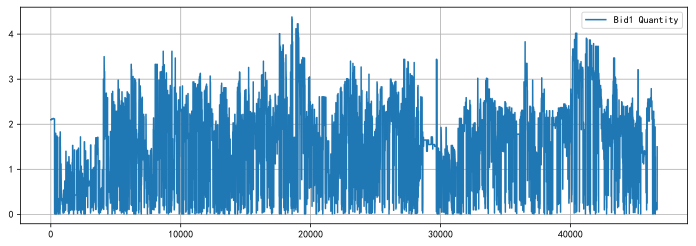

In [65]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12,4))
plt.grid()
plt.plot(bid_quantity_1,label = 'Bid1 Quantity')
# plt.xlim(0.0,25200)
plt.legend(loc = 1)

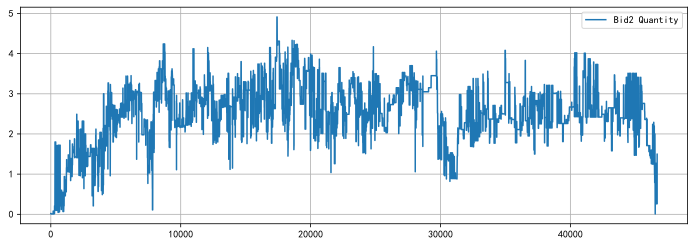

In [66]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12,4))
plt.grid()
plt.plot(bid_quantity_2,label = 'Bid2 Quantity')
# plt.xlim(0.0,25200)
plt.legend(loc = 1)

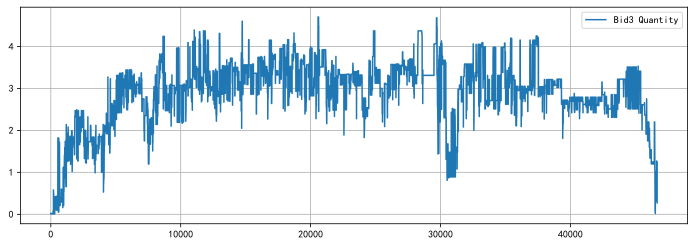

In [67]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12,4))
plt.grid()
plt.plot(bid_quantity_3,label = 'Bid3 Quantity')
# plt.xlim(0.0,25200)
plt.legend(loc = 1)

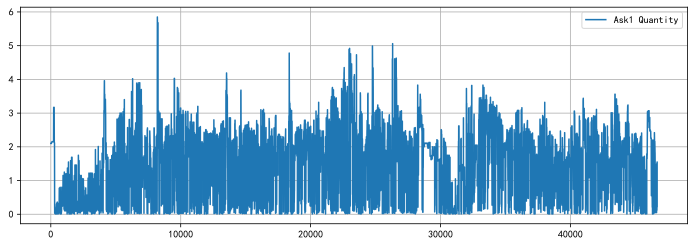

In [68]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12,4))
plt.grid()
plt.plot(ask_quantity_1,label = 'Ask1 Quantity')
# plt.xlim(0.0,25200)
plt.legend(loc = 1)

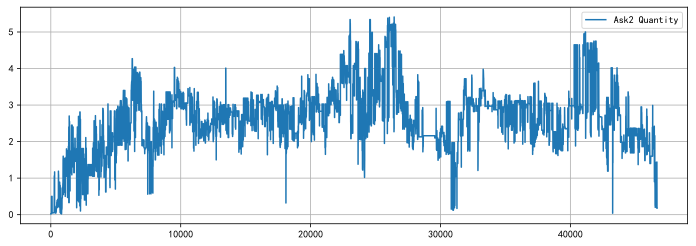

In [69]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12,4))
plt.grid()
plt.plot(ask_quantity_2,label = 'Ask2 Quantity')
# plt.xlim(0.0,25200)
plt.legend(loc = 1)

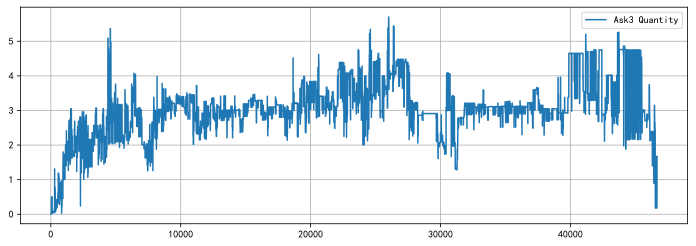

In [70]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12,4))
plt.grid()
plt.plot(ask_quantity_3,label = 'Ask3 Quantity')
# plt.xlim(0.0,25200)
plt.legend(loc = 1)

### **Spread**

In [87]:
spread = (Ask1-Bid1)*2*10000/(Ask1+Bid1)
spread

array([14.07459536, 21.11932418,  7.04473406, ...,  0.        ,
        0.        ,  7.10479574])

<AxesSubplot:ylabel='Count'>

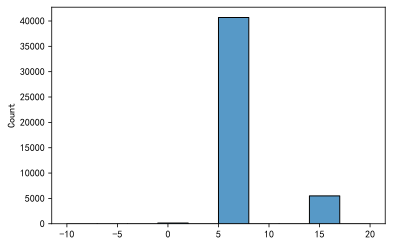

In [88]:
sns.histplot(spread, bins=10, binrange=(-10, 20))

<AxesSubplot:ylabel='Density'>

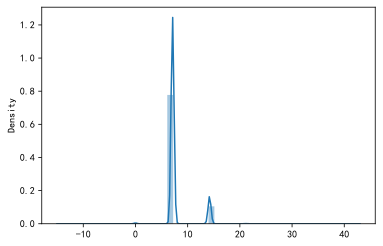

In [80]:
sns.distplot(spread)

In [89]:
min_Ask1_16_time_series = []
min_Ask1_16_time_series.append(0)
for i in range(1,len(Ask1),1):
    min_Ask1_16_time_series.append(min(Ask1[i:]))

In [90]:
max_Bid1_16_time_series = []
max_Bid1_16_time_series.append(0)
for i in range(1,len(Bid1),1):
    max_Bid1_16_time_series.append(max(Bid1[i:]))

In [108]:
min_Ask1_16_time_series[2]

7000.0

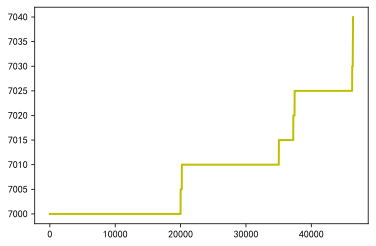

In [111]:
plt.plot(min_Ask1_16_time_series[5:],label = 'min Ask1 (close)', linewidth = 2,color = 'y')


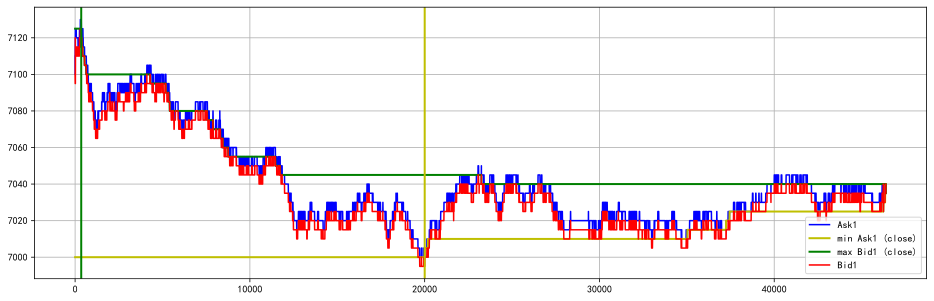

In [112]:
plt.figure(figsize = (16,5))
plt.grid()
plt.plot(Ask1, label = 'Ask1',color = 'b')
# plt.plot(Ask2[0:data_trade_time_series_0900_0930],label = 'Ask2')
#plt.plot(Ask3[0:data_trade_time_series_0900_0930],label = 'Ask3')
plt.plot(min_Ask1_16_time_series[1:],label = 'min Ask1 (close)', linewidth = 2,color = 'y')
plt.plot(max_Bid1_16_time_series[1:],label = 'max Bid1 (close)', linewidth = 2,color = 'g')

plt.plot(Bid1,label = 'Bid1',color = 'r')
#plt.plot(Bid2[0:data_trade_time_series_0900_0930],label = 'Bid2')
#plt.plot(Bid3[0:data_trade_time_series_0900_0930],label = 'Bid3')
# plt.ylim(6710,6810)
plt.legend(loc = 4)
index1 = np.where(np.array(max_Bid1_16_time_series) == max(max_Bid1_16_time_series[0:len(Ask1)]))[0][-1]
plt.axvline(x = index1 ,color = 'g',linestyle = '-',label = 0.4, linewidth = 2)
index2 = np.where(np.array(min_Ask1_16_time_series) == np.unique(min_Ask1_16_time_series[0:len(Ask1)][1]))[0][-1]
plt.axvline(x = index2 ,color = 'y',linestyle = '-',label = 0.4, linewidth = 2)
